In [12]:
from collections import defaultdict
from itertools import product

from tqdm import tqdm
import polars as pl
import pandas as pd
import os
import seaborn as sns
import matplotlib.pyplot as plt
from upsetplot import UpSet, from_memberships
import warnings

# Ignore future warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

plt.rcParams['figure.dpi'] = 300
sns.set_palette("colorblind")
# Set font size
plt.rcParams.update({'font.size': 16})

In [13]:
DETECTION_DIR = "detection"
QUANTIFICATION_DIR = "quantification"
OUT_DIR = "../chapters/4_results_and_discussion/figures/detection"
os.makedirs(OUT_DIR, exist_ok=True)
tools = [tool_csv[:-4] for tool_csv in os.listdir(DETECTION_DIR)]
tools

['ciri2', 'circexplorer2', 'find_circ', 'dcc', 'segemehl']

In [14]:
def parse_locstring(locstring: str):
    chrom, coords, strand = locstring.split(":")
    start, end = coords.split("-")
    return {"chr": chrom, "start": int(start), "end": int(end), "strand": strand}

In [15]:
tool_dfs = [
    pl.scan_csv(os.path.join(DETECTION_DIR, f"{tool}.csv"), separator='\t')
        .with_columns(tool=pl.lit(tool))
    for tool in tools
]

samples = tool_dfs[0].drop("id", "tool").collect_schema()

tool_dfs = [df.select("id", "tool", *samples).with_columns(**{sample: pl.col(sample).cast(int) for sample in samples}) for df in tool_dfs]

df = pl.concat(tool_dfs)

df = df.with_columns(
    total_counts=pl.sum_horizontal(samples),
    n_samples=pl.sum_horizontal(pl.col(samples).is_not_null()),
    location=pl.col("id").map_elements(parse_locstring, return_dtype=pl.Struct)
)

df = df.with_columns(
    mean_counts=pl.col("total_counts") / pl.col("n_samples")
)

df = df.with_columns(
    chr=pl.col("location").map_elements(lambda x: x["chr"], return_dtype=str),
    start=pl.col("location").map_elements(lambda x: x["start"], return_dtype=int),
    end=pl.col("location").map_elements(lambda x: x["end"], return_dtype=int),
    strand=pl.col("location").map_elements(lambda x: x["strand"], return_dtype=str)
)

df = df.select("tool", "chr", "start", "end", "strand", "total_counts", "n_samples", "mean_counts")

In [16]:
df = df.with_columns(start=pl.when(pl.col("tool").is_in(["ciri2", "dcc"])).then(pl.col("start") -1).otherwise(pl.col("start")))
df = df.with_columns(strand=pl.when(pl.col("tool").is_in(["dcc", "segemehl"])).then(pl.col("strand").map_elements(lambda x: "-" if x == "+" else "+")).otherwise(pl.col("strand")))

In [17]:
df = df.collect().lazy()

sys:1: MapWithoutReturnDtypeWarning: Calling `map_elements` without specifying `return_dtype` can lead to unpredictable results. Specify `return_dtype` to silence this warning.
sys:1: MapWithoutReturnDtypeWarning: Calling `map_elements` without specifying `return_dtype` can lead to unpredictable results. Specify `return_dtype` to silence this warning.
sys:1: MapWithoutReturnDtypeWarning: Calling `map_elements` without specifying `return_dtype` can lead to unpredictable results. Specify `return_dtype` to silence this warning.
sys:1: MapWithoutReturnDtypeWarning: Calling `map_elements` without specifying `return_dtype` can lead to unpredictable results. Specify `return_dtype` to silence this warning.
sys:1: MapWithoutReturnDtypeWarning: Calling `map_elements` without specifying `return_dtype` can lead to unpredictable results. Specify `return_dtype` to silence this warning.
sys:1: MapWithoutReturnDtypeWarning: Calling `map_elements` without specifying `return_dtype` can lead to unpredict

In [18]:
df_backup1 = df.clone()

In [19]:
df = df_backup1.clone()

In [20]:
max_shift = 3

df = df.select("chr", "start", "end", "strand", "tool").unique()

df = df.sort("end"  ).with_columns(end_group  =pl.col("end"  ).diff().fill_null(0).gt(max_shift).cum_sum())
df = df.sort("start").with_columns(start_group=pl.col("start").diff().fill_null(0).gt(max_shift).cum_sum())

df_with_groups = df

df = df.group_by("chr", "start", "end", "strand", "start_group", "end_group").agg(tools= pl.col("tool").unique())

group_cols = ["chr", "start_group", "end_group"]
df = df.join(df, on=group_cols, how="inner")
df = df.select("chr", "start", "end", "strand", "start_right", "end_right", "tools_right", "start_group", "end_group")
df = df.filter((pl.col("start") - pl.col("start_right")).abs() <= max_shift)
df = df.filter((pl.col("end") - pl.col("end_right")).abs() <= max_shift)
df = df.group_by("chr", "start", "end", "strand", "start_group", "end_group").agg(
    tools = pl.col("tools_right").flatten().unique()
).sort("chr", "start", "end", "strand")
df = df.with_columns(n_tools=pl.col("tools").map_elements(lambda x: len(x), return_dtype=int))
df = df.filter(pl.col("n_tools") == 5)

df_filtered = df

In [21]:
df = df_with_groups.join(df_filtered, on=["chr", "start", "end", "strand", "start_group", "end_group"], how="inner")
df = df.collect().lazy()
df.collect().head()

chr,start,end,strand,tool,end_group,start_group,tools,n_tools
str,i64,i64,str,str,u32,u32,list[str],i64
"""chr4_JH584295v1_random""",564,1475,"""-""","""dcc""",51,6,"[""segemehl"", ""circexplorer2"", … ""dcc""]",5
"""chr4_JH584295v1_random""",564,1475,"""-""","""ciri2""",51,6,"[""segemehl"", ""circexplorer2"", … ""dcc""]",5
"""chr4_JH584295v1_random""",564,1475,"""-""","""circexplorer2""",51,6,"[""segemehl"", ""circexplorer2"", … ""dcc""]",5
"""chr4_JH584295v1_random""",564,1475,"""-""","""find_circ""",51,6,"[""segemehl"", ""circexplorer2"", … ""dcc""]",5
"""chr4_JH584295v1_random""",564,1475,"""-""","""segemehl""",51,6,"[""segemehl"", ""circexplorer2"", … ""dcc""]",5


In [22]:
df = df.drop("tools", "n_tools")
df = df.select("chr", "start", "end", "start_group", "end_group").unique().join(df, on=group_cols, how="inner")
df = df.filter((pl.col("start") - pl.col("start_right")).abs() <= max_shift)
df = df.filter((pl.col("end") - pl.col("end_right")).abs() <= max_shift)
df = df.with_columns(strand=pl.col("strand").map_elements(lambda x: 1 if x == "+" else -1, return_dtype=int))
df = df.collect()
df.head()

chr,start,end,start_group,end_group,start_right,end_right,strand,tool
str,i64,i64,u32,u32,i64,i64,i64,str
"""chr4_JH584295v1_random""",564,1475,6,51,564,1475,-1,"""dcc"""
"""chr4_JH584295v1_random""",564,1475,6,51,564,1475,-1,"""ciri2"""
"""chr4_JH584295v1_random""",564,1475,6,51,564,1475,-1,"""circexplorer2"""
"""chr4_JH584295v1_random""",564,1475,6,51,564,1475,-1,"""find_circ"""
"""chr4_JH584295v1_random""",564,1475,6,51,564,1475,-1,"""segemehl"""


In [23]:
df_mean_locs = df.group_by("chr", "start", "end").agg(
    mean_start=pl.col("start_right").mean(),
    mean_end=pl.col("end_right").mean(),
    mean_strand=pl.col("strand").mean()
)
df_mean_locs.head()

chr,start,end,mean_start,mean_end,mean_strand
str,i64,i64,f64,f64,f64
"""chr8""",91832907,91833862,9.1832907e7,9.1833862e7,1.0
"""chr6""",120379466,120392315,1.20379466e8,1.20392315e8,1.0
"""chr12""",51806001,51807953,5.1806e7,5.1808e7,-1.0
"""chr4""",136284952,136288471,1.36284952e8,1.36288471e8,-1.0
"""chr11""",84785375,84788546,8.4785375e7,8.4788546e7,1.0


In [24]:
df = df.join(df_mean_locs, on=["chr", "start", "end"])
df.head()

chr,start,end,start_group,end_group,start_right,end_right,strand,tool,mean_start,mean_end,mean_strand
str,i64,i64,u32,u32,i64,i64,i64,str,f64,f64,f64
"""chr4_JH584295v1_random""",564,1475,6,51,564,1475,-1,"""dcc""",564.0,1475.0,-1.0
"""chr4_JH584295v1_random""",564,1475,6,51,564,1475,-1,"""ciri2""",564.0,1475.0,-1.0
"""chr4_JH584295v1_random""",564,1475,6,51,564,1475,-1,"""circexplorer2""",564.0,1475.0,-1.0
"""chr4_JH584295v1_random""",564,1475,6,51,564,1475,-1,"""find_circ""",564.0,1475.0,-1.0
"""chr4_JH584295v1_random""",564,1475,6,51,564,1475,-1,"""segemehl""",564.0,1475.0,-1.0


In [25]:
df = df.with_columns(
    start_delta=pl.col("start_right") - pl.col("mean_start"), 
    end_delta=pl.col("end_right") - pl.col("mean_end"), 
    strand_delta=pl.col("strand") - pl.col("mean_strand")
).select("chr", "start", "end", "tool", "start_delta", "end_delta", "strand_delta")
df.head()

chr,start,end,tool,start_delta,end_delta,strand_delta
str,i64,i64,str,f64,f64,f64
"""chr4_JH584295v1_random""",564,1475,"""dcc""",0.0,0.0,0.0
"""chr4_JH584295v1_random""",564,1475,"""ciri2""",0.0,0.0,0.0
"""chr4_JH584295v1_random""",564,1475,"""circexplorer2""",0.0,0.0,0.0
"""chr4_JH584295v1_random""",564,1475,"""find_circ""",0.0,0.0,0.0
"""chr4_JH584295v1_random""",564,1475,"""segemehl""",0.0,0.0,0.0


In [26]:
df_strand_delta = df.pivot("tool", index=["chr", "start", "end"], values="strand_delta", aggregate_function="mean").select(*tools)
df_strand_delta = pd.DataFrame(df_strand_delta, columns=tools)
df_strand_delta.head()

,ciri2,circexplorer2,find_circ,dcc,segemehl
0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0


In [27]:
df.select("start_delta", "end_delta", "strand_delta").describe()

statistic,start_delta,end_delta,strand_delta
str,f64,f64,f64
"""count""",80050.0,80050.0,80050.0
"""null_count""",0.0,0.0,0.0
"""mean""",-1.9790e-11,1.6271e-11,-5.3257e-19
"""std""",0.262171,0.266735,0.147042
"""min""",-3.9,-3.181818,-1.777778
"""25%""",0.0,0.0,0.0
"""50%""",0.0,0.0,0.0
"""75%""",0.0,0.0,0.0
"""max""",3.375,3.0,1.846154


In [28]:
df = pd.DataFrame(df, columns=df.columns)
df.head()

,chr,start,end,tool,start_delta,end_delta,strand_delta
0,chr4_JH584295v1_random,564,1475,dcc,0.0,0.0,0.0
1,chr4_JH584295v1_random,564,1475,ciri2,0.0,0.0,0.0
2,chr4_JH584295v1_random,564,1475,circexplorer2,0.0,0.0,0.0
3,chr4_JH584295v1_random,564,1475,find_circ,0.0,0.0,0.0
4,chr4_JH584295v1_random,564,1475,segemehl,0.0,0.0,0.0


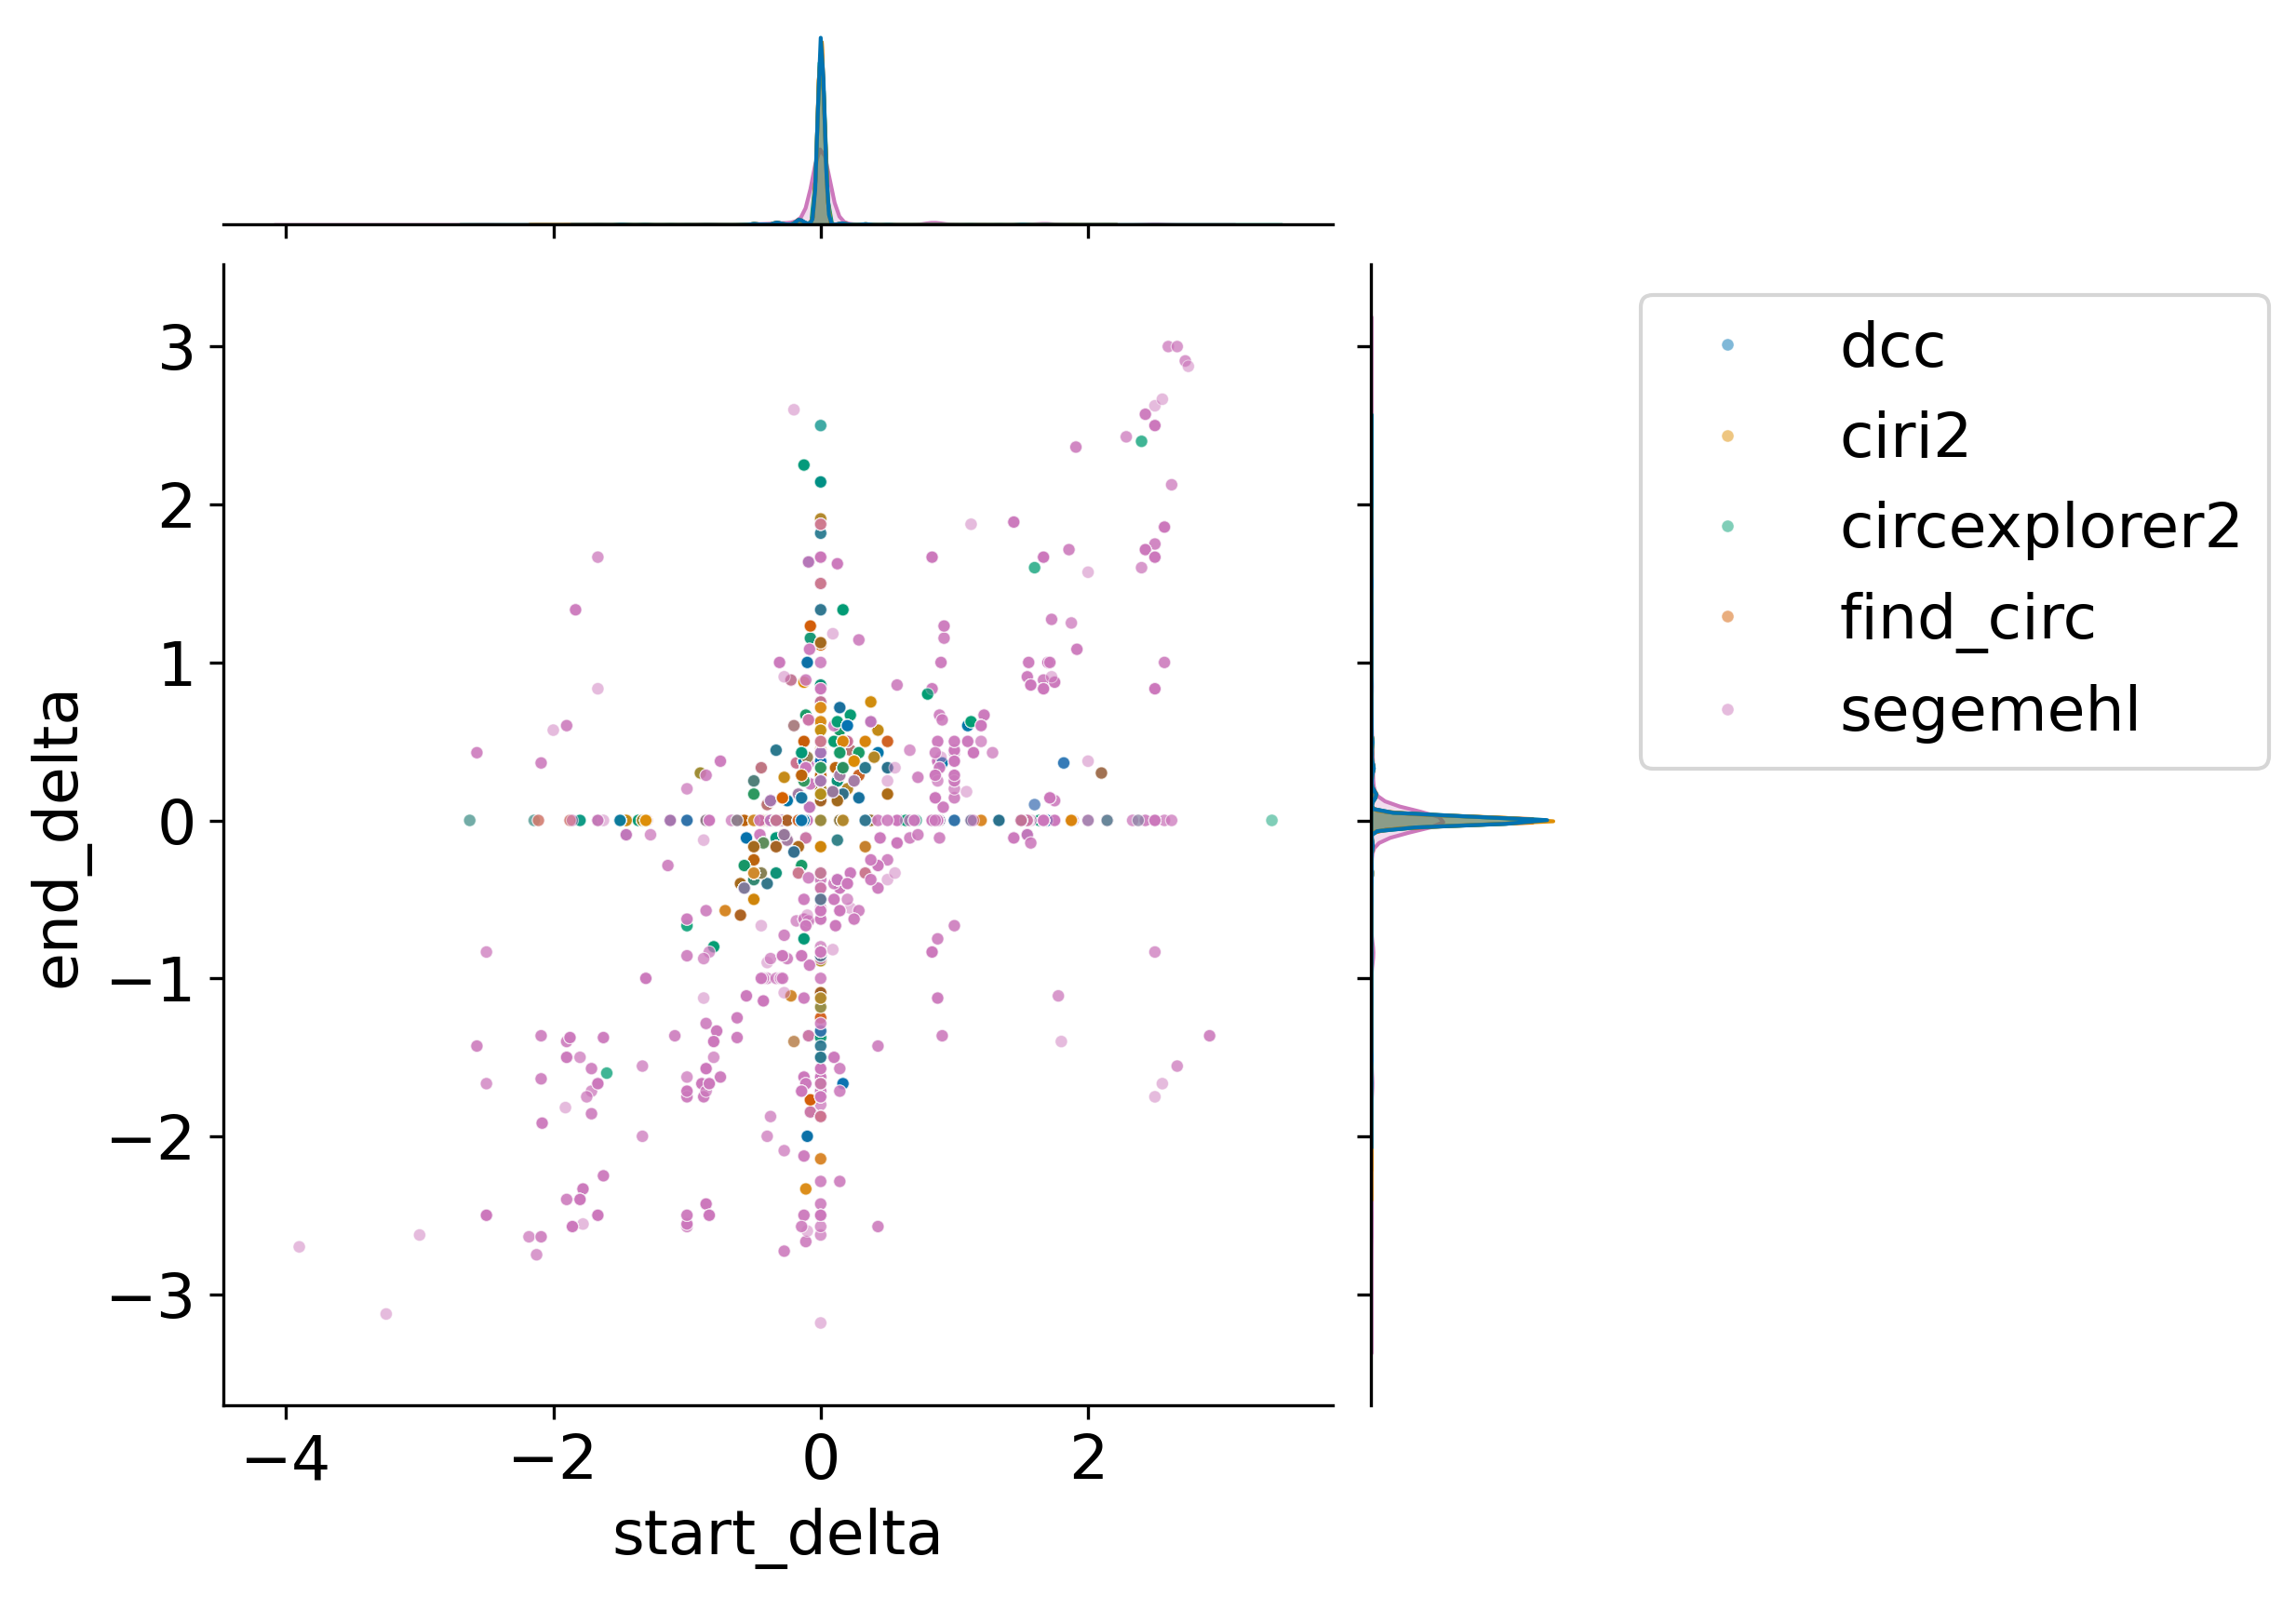

In [29]:
sns.jointplot(data=df, x="start_delta", y="end_delta", hue="tool", alpha=0.5, s=10)
# Put legend out of the figure, give it full opacity
plt.legend(bbox_to_anchor=(1.25, 1), loc=2)

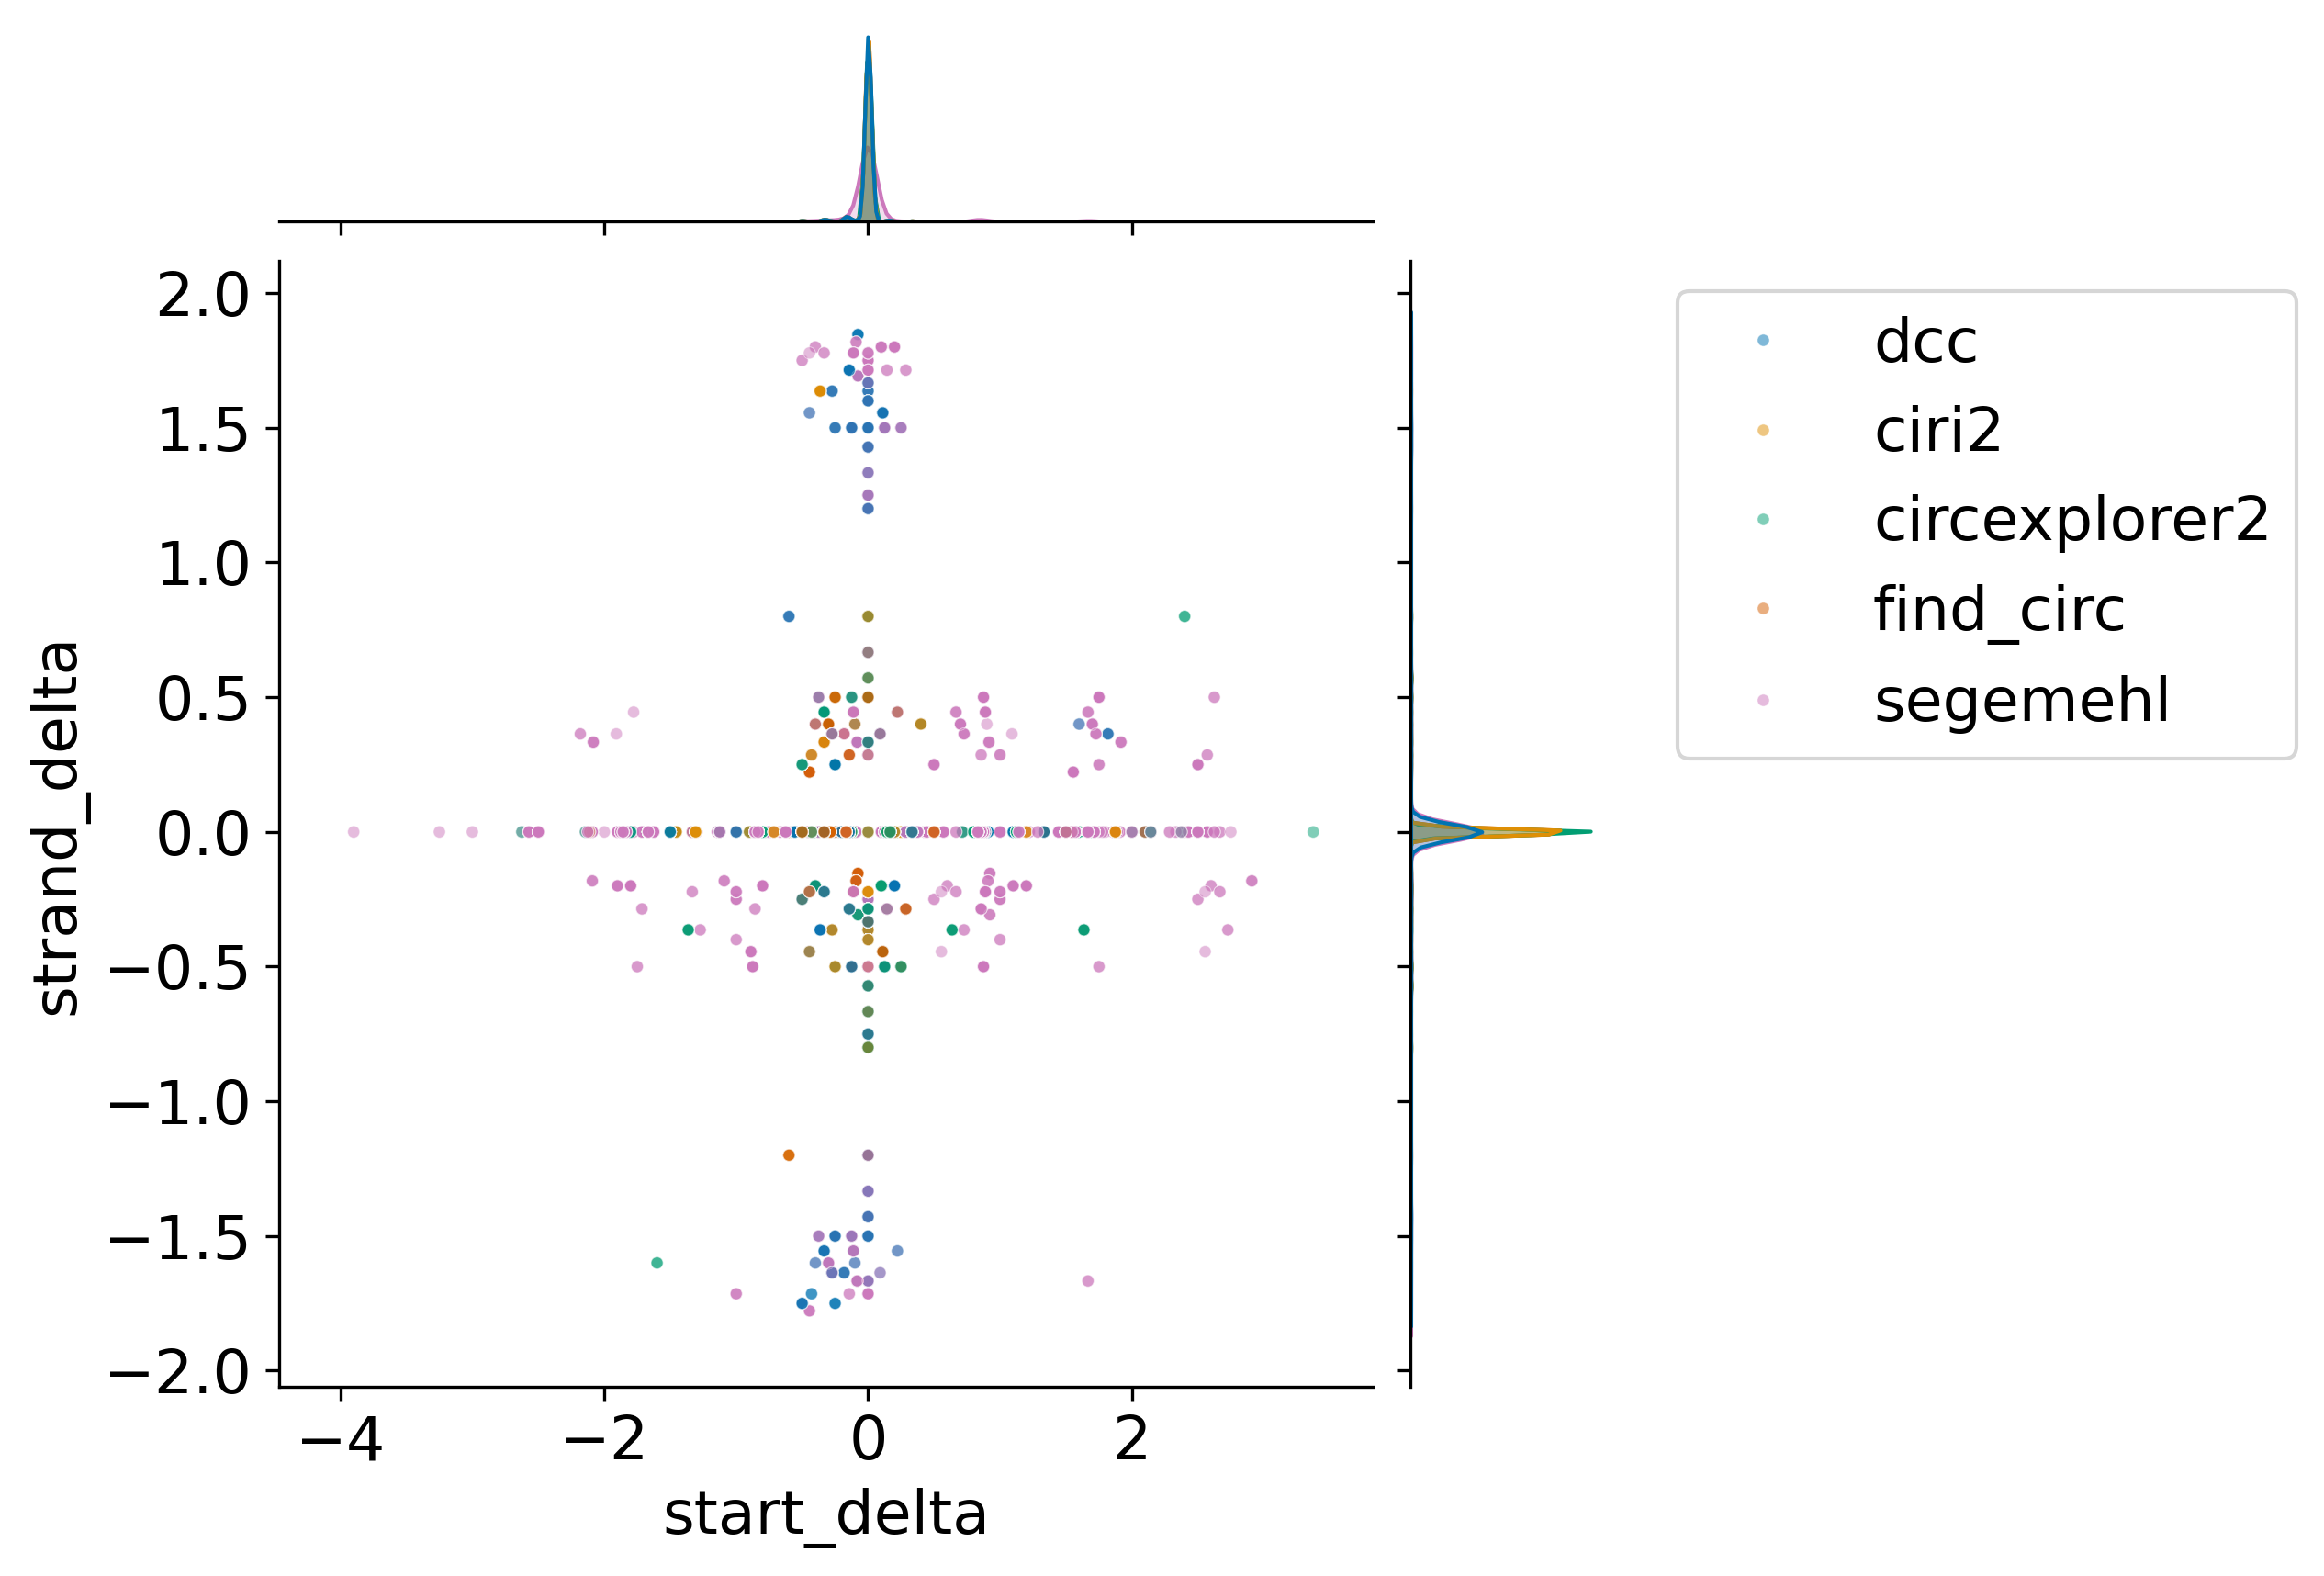

In [30]:
sns.jointplot(data=df, x="start_delta", y="strand_delta", hue="tool", alpha=0.5, s=10)
# Put legend out of the figure, give it full opacity
plt.legend(bbox_to_anchor=(1.25, 1), loc=2)

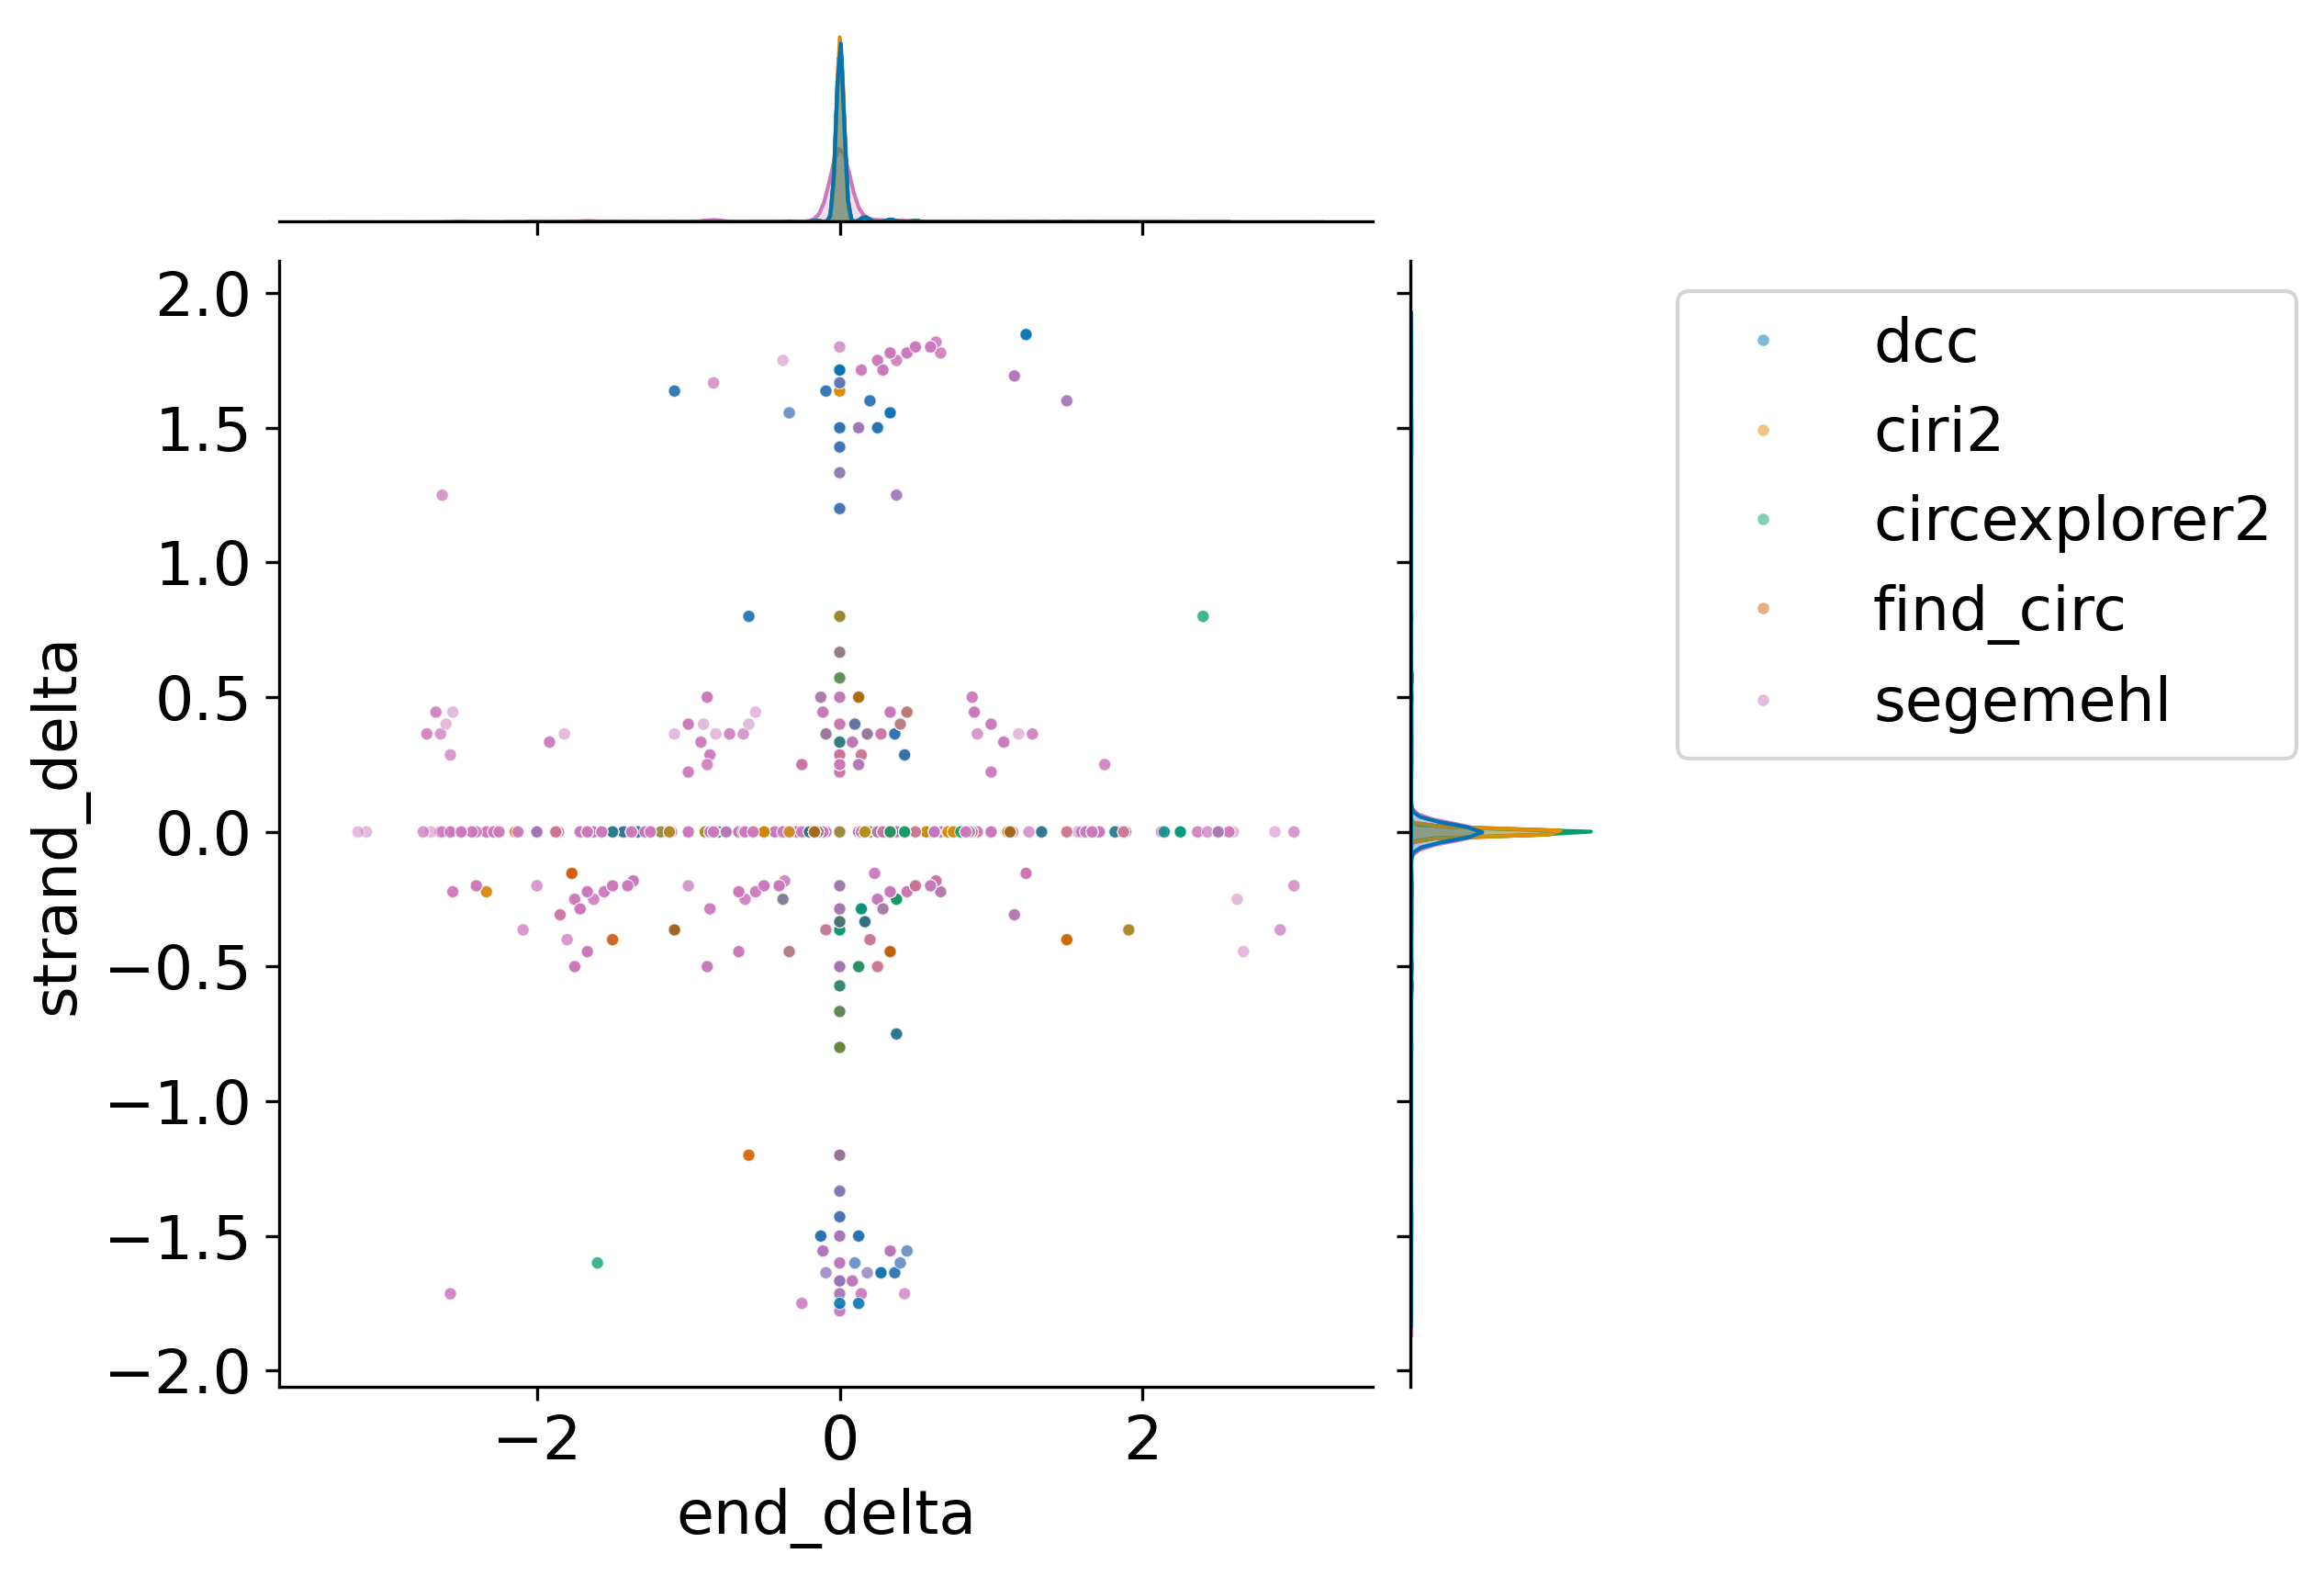

In [31]:
sns.jointplot(data=df, x="end_delta", y="strand_delta", hue="tool", alpha=0.5, s=10)
# Put legend out of the figure, give it full opacity
plt.legend(bbox_to_anchor=(1.25, 1), loc=2)

In [33]:
df_strand_delta

,ciri2,circexplorer2,find_circ,dcc,segemehl
0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...
15278,0.0,0.0,0.0,0.0,0.0
15279,0.0,0.0,0.0,0.0,0.0
15280,0.0,0.0,0.0,0.0,0.0
15281,0.0,0.0,0.0,0.0,0.0


<Axes: >

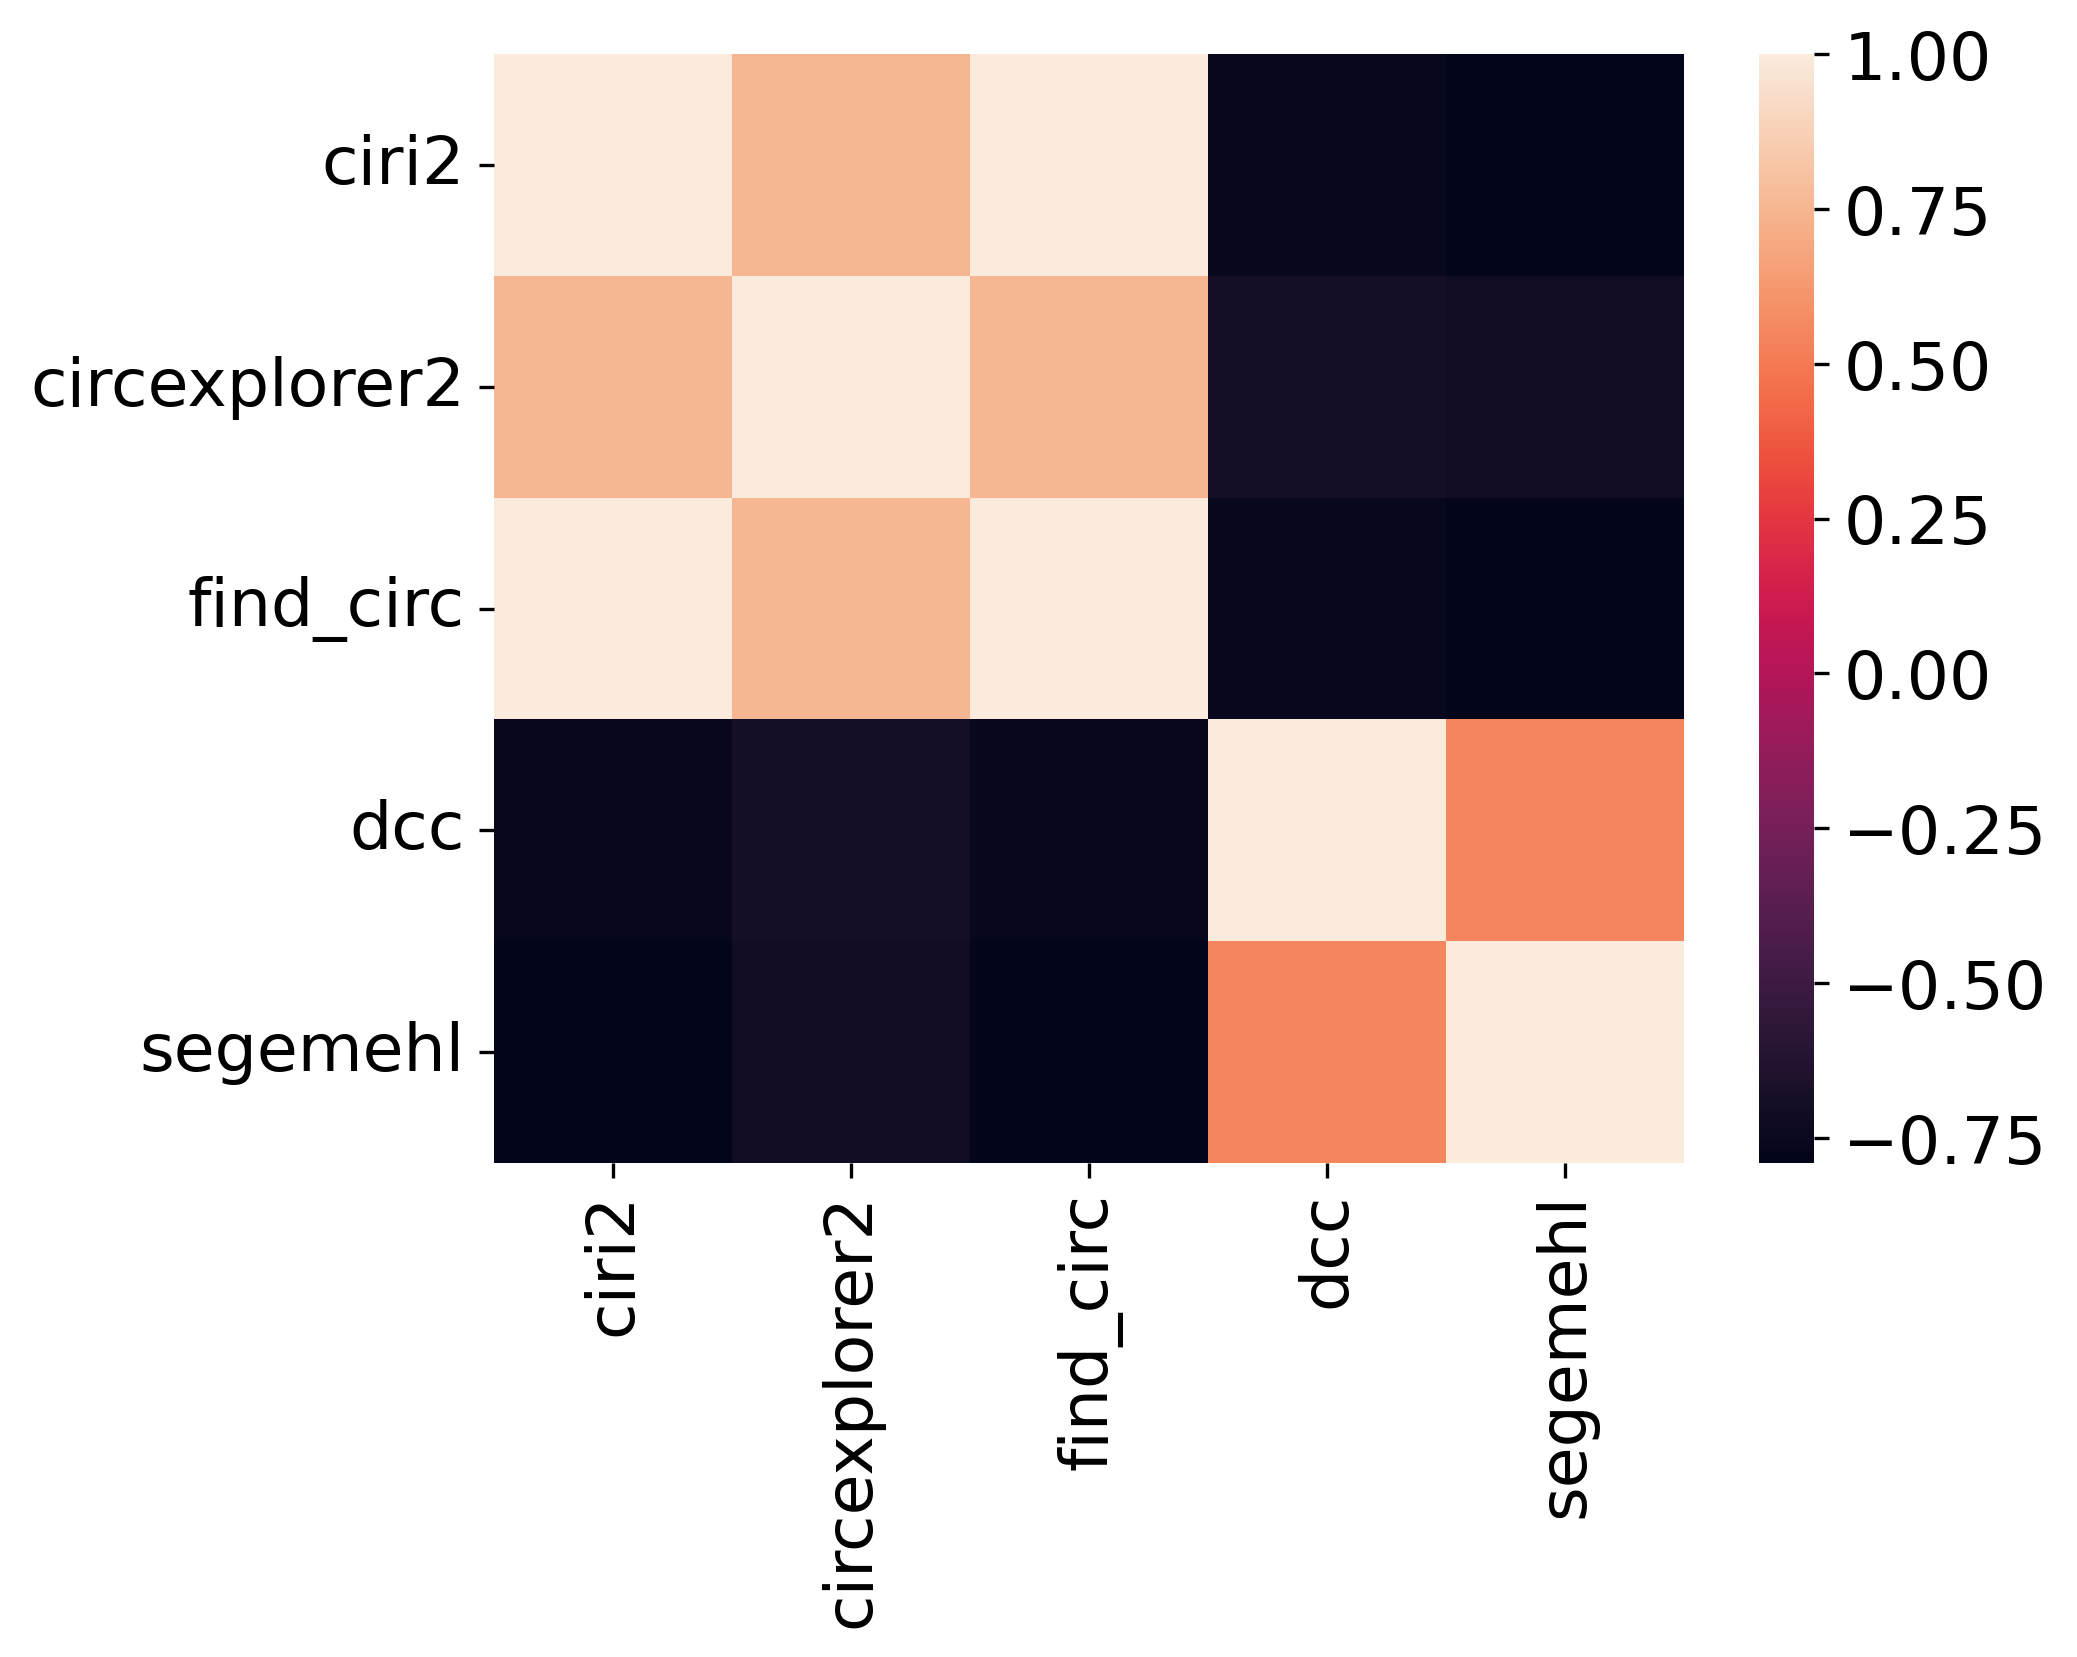

In [32]:
sns.heatmap(df_strand_delta.corr())